In [3]:
import numpy as np
import random
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from scipy.spatial.distance import cdist
from itertools import combinations
from numpy.lib.stride_tricks import sliding_window_view
from time import time

In [4]:
def calculate_average(*args,**kwargs):
    return np.mean(args)

In [5]:
def calculate_cost(data: np.ndarray) -> np.ndarray:
    costs = cdist(data[:,2].reshape(-1,1), data[:,2].reshape(-1,1),calculate_average)
    distances = np.round(cdist(data[:,:2], data[:,:2], 'euclidean'))
    distances = distances + costs
    return distances

In [6]:
def random_initial_solution(data: np.ndarray) -> np.ndarray:
    """
    Creates shuffled array of indices with size equal to half of the data points.
    :param data: Data points
    :type data: np.ndarray
    :return: Data indices of nodes contained in initial solutions
    :rtype: np.ndarray
    """
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    order = indices[:len(data)//2]
    return order

In [7]:
def create_node_exchange_neighborhood(order: np.ndarray, num_of_all_points: int) -> np.ndarray:
    ind = np.arange(len(order))
    #Inter-route
    indices_for_all_data = np.arange(num_of_all_points)
    not_selected = np.setdiff1d(indices_for_all_data, order)
    XX, YY = np.meshgrid(ind,not_selected)
    inter_route = np.dstack([XX,YY]).reshape(-1, 2)
    is_inter_route = np.zeros((inter_route.shape[0],1),dtype=np.int32)
    inter_route = np.concatenate((is_inter_route,inter_route),1)
    return inter_route

In [8]:
def create_neighborhood(order: np.ndarray, num_of_all_points: int) -> np.ndarray:
    """
    Creates every possible move.
    ------------
    Inter-route
        Creates every possible combination of adding a new node to the nodes contained in the solution
    Edge exchange
        Creates every possible combination of pairs contained in the solution

    :param order: Array of indices contained in the solution
    :type order: np.ndarray
    :param num_of_all_points: Number of all data points
    :type num_of_all_points: int
    :return: Neighborhood with first column defining whether move is inter-route and the following columns defining move.
    :rtype:
    """
    ind = np.arange(len(order))
    #Inter-route
    inter_route = create_node_exchange_neighborhood(order,num_of_all_points)
    # #Edge exchange
    edge_ex = np.array(list(combinations(ind, 2)))
    is_inter_route = np.ones((edge_ex.shape[0],1),dtype=np.int32)
    edge_ex = np.concatenate((is_inter_route,edge_ex),1)
    # return edge_ex
    neighborhood = np.vstack((inter_route,edge_ex))
    return neighborhood
    # return edge_ex

In [9]:
def calculate_value(data: np.ndarray, distances: np.ndarray, order: np.ndarray) -> tuple:
    """
    :param data: Data points
    :type data: np.ndarray
    :param distances: Distance matrix
    :type distances: np.ndarray
    :param order: Array of indices contained in the solution
    :type order: np.ndarray
    :return: Tuple containing score for the current solution and data points corresponding to the solution
    :rtype:
    """
    order = np.append(order,order[0])
    x,y =sliding_window_view(order.reshape(1,-1),(1,2)).reshape(-1,2).T
    value = distances[x,y].sum()
    path = data[order]
    return value, path

In [10]:
def calculate_deltas_for_node_exchange_moves(order:np.ndarray, distances: np.ndarray, possible_inter_moves: np.ndarray) -> np.ndarray:

    left_neighbors = order[possible_inter_moves[:,1] -1]
    right_neighbors = order[np.remainder(possible_inter_moves[:,1] +1, len(order))]
    currently_chosen_nodes = order[possible_inter_moves[:,1]]
    current_distances = distances[left_neighbors,currently_chosen_nodes] + distances[currently_chosen_nodes,right_neighbors]

    possible_new_nodes = possible_inter_moves[:,2]
    possible_new_distances = distances[left_neighbors,possible_new_nodes] + distances[possible_new_nodes,right_neighbors]

    all_deltas = current_distances - possible_new_distances
    improving_moves_mask = all_deltas>0


    improving_deltas = all_deltas[improving_moves_mask].reshape(-1,1).astype(np.int32)

    improving_moves = possible_inter_moves[improving_moves_mask]
    improving_moves = np.concatenate((improving_deltas,improving_moves),axis=1)
    return improving_moves

In [11]:
def calculate_deltas_for_edge_exchange(order:np.ndarray, distances: np.ndarray, possible_edge_exchange_moves: np.ndarray) -> np.ndarray:
    left_nodes = order[possible_edge_exchange_moves[:,1]]
    left_nodes_predecessors = order[possible_edge_exchange_moves[:,1] -1]

    right_nodes = order[possible_edge_exchange_moves[:,2]]
    right_nodes_predecessors = order[possible_edge_exchange_moves[:,2] -1]

    current_distances = distances[left_nodes,left_nodes_predecessors] + distances[right_nodes,right_nodes_predecessors]
    distances_after_edge_swap = distances[left_nodes,right_nodes] + distances[left_nodes_predecessors,right_nodes_predecessors]

    all_deltas = current_distances - distances_after_edge_swap
    improving_moves_mask = all_deltas>0


    improving_deltas = all_deltas[improving_moves_mask].reshape(-1,1).astype(np.int32)
    improving_moves = possible_edge_exchange_moves[improving_moves_mask]
    improving_moves = np.concatenate((improving_deltas,improving_moves),axis=1)
    return improving_moves

In [12]:
def calculate_deltas(order: np.ndarray, distances: np.ndarray, neighborhood: np.ndarray) -> np.ndarray:
    possible_inter_moves = neighborhood[neighborhood[:,0] == 0]
    improving_inter_moves = calculate_deltas_for_node_exchange_moves(order=order,
                                                                   distances=distances,
                                                                   possible_inter_moves=possible_inter_moves)

    possible_edge_exchange_moves = neighborhood[neighborhood[:,0] != 0]

    improving_edge_exchange_moves = calculate_deltas_for_edge_exchange(order=order,
                                                                       distances=distances,
                                                                       possible_edge_exchange_moves=possible_edge_exchange_moves)

    all_improving_moves = np.concatenate((improving_inter_moves,improving_edge_exchange_moves),axis=0)

    sorted_improving_moves = all_improving_moves[all_improving_moves[:,0].argsort()[::-1]]

    return sorted_improving_moves

In [13]:
def remove_not_applicable_moves(deltas:np.ndarray,best_move: np.ndarray) -> np.ndarray:
    node_exchange_moves = deltas[:,1] == 0
    edge_exchange_moves = deltas[:,1] == 1

    cond = np.bitwise_and(node_exchange_moves,deltas[:,3] ==  best_move[3])

    not_applicable_moves = cond
    return deltas[~not_applicable_moves]

In [14]:
def update_order_node_exchange(order:np.ndarray, best_move: np.ndarray) -> np.ndarray:
    order[best_move[2]] = best_move[3]
    return order

In [15]:
def update_order_edge_exchange(order:np.ndarray, best_move: np.ndarray) -> np.ndarray:
    ind = sorted([best_move[2], best_move[3]])
    if ind[0] == 0:
        order = np.concatenate((order[ind[1]-1::-1],order[ind[1]:]))
    else:
        order = np.concatenate((order[:ind[0]],order[ind[1]-1:ind[0]-1:-1],order[ind[1]:]))
    return order

In [16]:
def get_moves_to_recalculate_node_exchange(order:np.ndarray,deltas: np.ndarray, best_move: np.ndarray) -> np.ndarray:
    node_exchange_moves = deltas[:,1] == 0
    edge_exchange_moves = deltas[:,1] == 1

    cond1 = np.bitwise_and(node_exchange_moves,deltas[:,2] == best_move[2])
    cond2 = np.bitwise_and(node_exchange_moves,deltas[:,2] == (best_move[2] - 1) % len(order))
    cond3 = np.bitwise_and(node_exchange_moves,deltas[:,3] == best_move[3])
    cond4 = np.bitwise_and(node_exchange_moves,deltas[:,2] == (best_move[2] +1) % len(order))

    cond5 = np.bitwise_and(edge_exchange_moves,deltas[:,2] == best_move[2])
    cond6 = np.bitwise_and(edge_exchange_moves,deltas[:,2] == (best_move[2] +1) % len(order))
    cond9 = np.bitwise_and(edge_exchange_moves,deltas[:,3] == best_move[2])
    cond10 = np.bitwise_and(edge_exchange_moves,deltas[:,3] == (best_move[2] +1) % len(order))

    moves_to_remove = cond1 | cond2 | cond3 | cond4 | cond5 | cond6 | cond9 | cond10
    return moves_to_remove

In [17]:
def create_new_moves(order: np.ndarray, removed_node: int) -> np.ndarray:
    ind = np.arange(len(order))
    removed_node = np.array([removed_node])
    XX, YY = np.meshgrid(ind,removed_node)
    inter_route = np.dstack([XX,YY]).reshape(-1, 2)
    is_inter_route = np.zeros((inter_route.shape[0],1),dtype=np.int32)
    inter_route = np.concatenate((is_inter_route,inter_route),1)
    return inter_route

In [18]:
def get_moves_to_recalculate_edge_exchange(deltas: np.ndarray, best_move: np.ndarray) -> np.ndarray:
    node_exchange_moves = deltas[:,1] == 0

    cond1 = np.bitwise_and(node_exchange_moves,deltas[:,2] == best_move[2])
    cond2 = np.bitwise_and(node_exchange_moves,deltas[:,2] == (best_move[2] -1) % len(order))
    cond3 = np.bitwise_and(node_exchange_moves,deltas[:,2] == (best_move[3] -1) % len(order))
    cond4 = np.bitwise_and(node_exchange_moves,deltas[:,2] == best_move[3])

    moves_to_remove = cond1 | cond2 | cond3 | cond4
    return moves_to_remove

In [19]:
def local_search_steepest(order, distances):
    neighborhood = create_neighborhood(order=order,num_of_all_points=len(data))
    deltas = calculate_deltas(order,distances,neighborhood)
    counter =0

    while len(deltas) > 0:
        counter +=1
        best_move = deltas[0]
        # print("best_move: ",best_move)
        if best_move[1] == 0:
            deltas = remove_not_applicable_moves(deltas,best_move)
            new_deltas = create_new_moves(order,order[best_move[2]])

            order = update_order_node_exchange(order,best_move=best_move)
            moves_to_recalculate = get_moves_to_recalculate_node_exchange(order,deltas, best_move)

            # print("node exchange to recalculate: \n",deltas[moves_to_recalculate])
            nodes_moves = deltas[:,1] ==0

            deltas_to_recalculate = np.concatenate((deltas[moves_to_recalculate,1:],new_deltas),axis=0)
            updated_deltas = calculate_deltas(order, distances, deltas_to_recalculate)
            # print("node exchange after recalculate: \n",updated_deltas)

            deltas = np.concatenate((deltas[~moves_to_recalculate],updated_deltas),axis=0)
            deltas = deltas[deltas[:,0].argsort()[::-1]]
            # print("all deltas \n",deltas[:5])

        elif best_move[1] == 1:
            order = update_order_edge_exchange(order,best_move)
            updated_deltas = calculate_deltas(order,distances,neighborhood[neighborhood[:,0] ==1])
            new_deltas = calculate_deltas(order,distances,create_node_exchange_neighborhood(order,len(data)))

            deltas = np.concatenate((new_deltas,updated_deltas),axis=0)
            deltas = deltas[deltas[:,0].argsort()[::-1]]
    return order

In [79]:
def MSLS(data, distances, iterations=200):
    best_solution = (9999999999, None)
    for _ in range(iterations):
        order = local_search_steepest(random_initial_solution(data), distances)
        best_solution = min(best_solution, calculate_value(data, distances, order))
    return best_solution

In [89]:
def perturb(order, num_of_all_points, break_chance=0.1, node_exchange_chance=0.5):
    indices_for_all_data = np.arange(num_of_all_points)
    not_selected = np.setdiff1d(indices_for_all_data, order)
    while random.random() > break_chance:
        A = [random.randrange(len(order))]
        if random.random() > node_exchange_chance:
            B = [random.choice(not_selected)]
            order = update_order_node_exchange(order, [None, None]+A+B)
        else:
            B = [random.randrange(len(order))]
            order = update_order_edge_exchange(order, [None, None]+A+B)
    return order

In [87]:
def ILS(data, distances, running_time=22.603053414821623): #running_time ma być average z poprzedniej metody
    best_solution = (9999999999, None)
    order = random_initial_solution(data)
    start = time()
    while(running_time > time() - start):
        order = local_search_steepest(order, distances)
        best_solution = min((best_solution, calculate_value(data, distances, order)), key = lambda t: t[0])
        order = perturb(order, len(data))
    return best_solution

In [78]:
print(MSLS(data, distances, 50))
ILS(data, distances, 2)

((49815.0, array([[1970,  134,  239],
       [1424,   69,   75],
       [1100,   39,   15],
       [1047,  194,  208],
       [ 580,   83,  148],
       [ 172,   37,  116],
       [  52,  109,  238],
       [ 243,  232,   17],
       [ 495,  227,   96],
       [ 665,  175,  304],
       [ 728,  505,  511],
       [ 290,  766,  111],
       [ 183,  867,  281],
       [  34, 1105,  224],
       [ 154, 1204,  261],
       [ 334, 1269,  450],
       [ 664, 1168,  124],
       [ 671, 1320,   37],
       [ 628, 1342,   60],
       [ 920, 1504,  550],
       [ 936, 1648,  577],
       [1055, 1629,  232],
       [1109, 1824,  422],
       [1119, 1848,  418],
       [1433, 1792,  319],
       [1612, 1918,  215],
       [1481, 1516,  321],
       [1266, 1534,  362],
       [1278, 1463,  514],
       [1292, 1392,  135],
       [1157, 1413,  287],
       [1184, 1380,  686],
       [1187, 1284,  169],
       [1023, 1258,   98],
       [1186, 1152,   16],
       [1032,  882,  392],
       [ 949,  79

(48884.0,
 array([[3535, 1302,  186],
        [3510, 1368,   74],
        [3421, 1686,  425],
        [3184, 1494,  320],
        [3121, 1452,  558],
        [3101, 1318,  409],
        [3072, 1182,   97],
        [2947, 1033,  497],
        [3193,  878,  437],
        [3359,  668,  191],
        [3637,  451,  454],
        [3773,  355,   68],
        [3977,  306,  252],
        [3915,   36,  374],
        [3606,  116,  223],
        [3531,  102,  216],
        [3381,  416,  383],
        [3181,  580,  379],
        [3050,  426,   82],
        [2993,  313,   28],
        [3042,  123,  241],
        [2963,  116,   55],
        [2955,    1,  332],
        [2888,   86,  527],
        [2605,    3,  182],
        [2357,  227,  380],
        [2105,  269,  270],
        [2125,  360,   72],
        [2055,  446,   71],
        [1878,  511,  318],
        [1899,  430,  342],
        [1812,  325,  328],
        [1674,  295,  194],
        [1510,  353,   42],
        [1549,  241,  553],
        [1

In [82]:
def evaluate(func, data, n=20):
    distances = calculate_cost(data)
    total, worst_value, best_value, best_solution = 0, 0, float('inf'), None
    total_time, worst_time, best_time = 0,0,float('inf')
    for _ in tqdm(range(n)):
        start = time()
        value, solution = func(data, distances)
        elapsed = time() - start
        total_time += elapsed
        if elapsed < best_time:
            best_time = elapsed
        worst_time = max(worst_time, elapsed)


        total += value
        if value < best_value:
            best_solution = solution
            best_value = value
        worst_value = max(worst_value, value)

    return dict(average_score=total / n,
                worst_score=worst_value,
                best_score=best_value,
                solution=np.array(best_solution).T,
                average_time=total_time / n,
                worst_time= worst_time,
                best_time = best_time)

In [85]:
def summarize(func, data, title):
    evaluation_results = evaluate(func=func,
                                    data=data,
                                     n = 20)
    (x, y, z) = evaluation_results["solution"]
    print(f'{title}:')
    print(f'average time: {evaluation_results["average_time"]}\tworst time: {evaluation_results["worst_time"]}\tbest time: {evaluation_results["best_time"]}')

    print(f'average score: {evaluation_results["average_score"]}\tworst score: {evaluation_results["worst_score"]}\tbest score: {evaluation_results["best_score"]}')
    print('Best solution:')

    plt.figure(figsize=(15,10))
    plt.scatter(data[:,0], data[:,1], np.full(data[:,0].size, 100), data[:,2], cmap='gray_r')
    plt.clim(0, 2000)
    plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
    plt.plot(x, y, 'r')
    plt.xlim([-100, 4100])
    plt.ylim([-100, 2100])
    plt.title(title)
    plt.show()


  0%|          | 0/20 [00:00<?, ?it/s]

MSLS:
average time: 22.603053414821623	worst time: 23.487688779830933	best time: 22.05062222480774
average score: 49187.7	worst score: 49679.0	best score: 48743.0
Best solution:


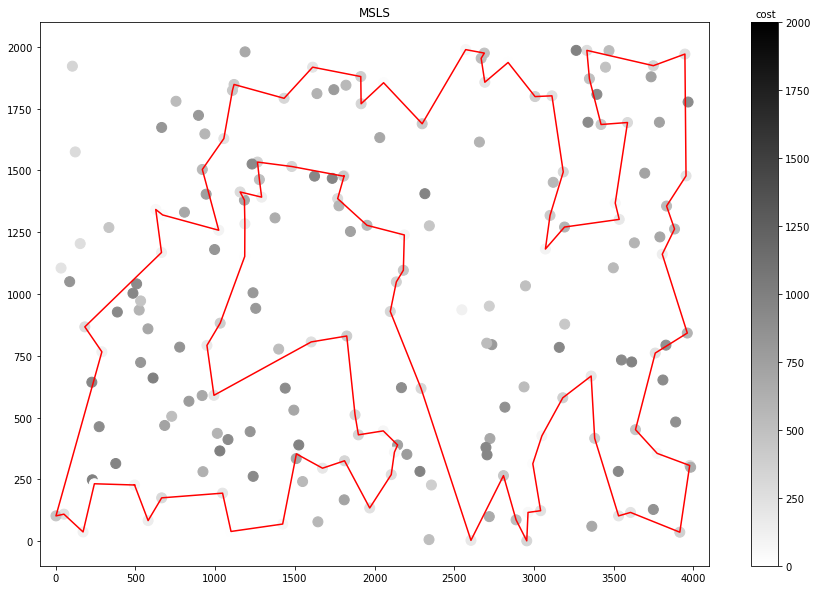

In [86]:
data = np.loadtxt('TSPC.csv', dtype=int, delimiter=';')
summarize(MSLS, data, 'MSLS')

  0%|          | 0/20 [00:00<?, ?it/s]

iLS:
average time: 10.017324125766754	worst time: 10.073946237564087	best time: 10.00141978263855
average score: 48643.2	worst score: 49721.0	best score: 47993.0
Best solution:


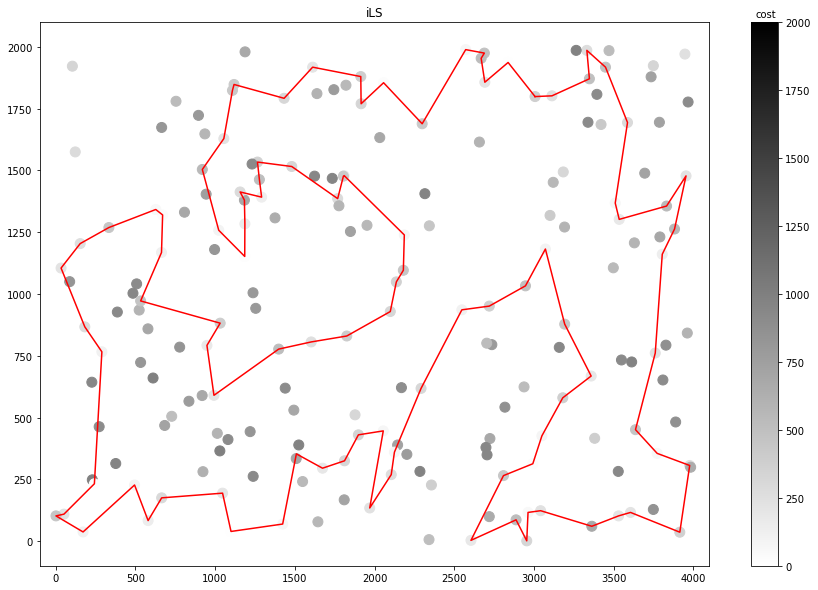

In [88]:
summarize(ILS, data, 'ILS')

In [24]:
# np.random.seed(0)
data = np.loadtxt('TSPC.csv', dtype=int, delimiter=';')
distances = calculate_cost(data)
# start  = time()
# order = random_initial_solution(data)
# neighborhood = create_neighborhood(order=order,num_of_all_points=len(data))
# deltas = calculate_deltas(order,distances,neighborhood)
# counter =0

# while len(deltas) > 0:
#     counter +=1
#     best_move = deltas[0]
#     # print("best_move: ",best_move)
#     if best_move[1] == 0:
#         deltas = remove_not_applicable_moves(deltas,best_move)
#         new_deltas = create_new_moves(order,order[best_move[2]])

#         order = update_order_node_exchange(order,best_move=best_move)
#         moves_to_recalculate = get_moves_to_recalculate_node_exchange(order,deltas, best_move)

#         # print("node exchange to recalculate: \n",deltas[moves_to_recalculate])
#         nodes_moves = deltas[:,1] ==0

#         deltas_to_recalculate = np.concatenate((deltas[moves_to_recalculate,1:],new_deltas),axis=0)
#         updated_deltas = calculate_deltas(order, distances, deltas_to_recalculate)
#         # print("node exchange after recalculate: \n",updated_deltas)

#         deltas = np.concatenate((deltas[~moves_to_recalculate],updated_deltas),axis=0)
#         deltas = deltas[deltas[:,0].argsort()[::-1]]
#         # print("all deltas \n",deltas[:5])

#     elif best_move[1] == 1:
#         order = update_order_edge_exchange(order,best_move)
#         updated_deltas = calculate_deltas(order,distances,neighborhood[neighborhood[:,0] ==1])
#         new_deltas = calculate_deltas(order,distances,create_node_exchange_neighborhood(order,len(data)))

#         deltas = np.concatenate((new_deltas,updated_deltas),axis=0)
#         deltas = deltas[deltas[:,0].argsort()[::-1]]
#     print(len(deltas))
# print(time() - start)